In [53]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


# Packages Import

In [54]:
pip install -q -U keras-tuner

In [55]:
pip install wget

In [56]:
import os
import string
import datetime
import gensim
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_tuner as kt
import tensorflow.keras as keras
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import os.path
import shutil
import wget

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input,concatenate,Activation, Dense, Dropout, Embedding, Flatten,Bidirectional, LSTM
from keras.models import Model
from keras.initializers import Constant
from keras.optimizers import Adam


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

# # Load the TensorBoard notebook extension
# %load_ext tensorboard
# # Clear any logs from previous runs on tensorboard
# !rm -rf ./logs/

In [57]:
# Changing the parameter of the column width for the display of the pandas dataframe
pd.set_option('display.max_colwidth',100)

In [58]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.5.0
Eager mode:  True
GPU is available


#Dataset import and features selection

In [59]:
#Check if the dataset is pre-downloaded in our working directory, otherwise we download it using the url location where is available
if not os.path.isfile('amazon_reviews.txt'):
    url = 'https://drive.google.com/uc?id=1-LYI_s6oZ0OTe3I0vFYRYIBVhjFswReY&export=download'
    print('Downloading DB to train')
    wget.download(url)
    print('Download Completed!\nUnzipping...')
    shutil.unpack_archive('amazon_reviews.zip')
else:
   print("The dataset is already downloaded")   
#The dataset is a tab seperated csv file therefore we define delimiter as delimiter = '/t'.
#We set index_col = False since we want to discard the entries with missing columns 
df = pd.read_csv('amazon_reviews.txt', error_bad_lines=False, delimiter="\t")
df.head()

The dataset is already downloaded


,DOC_ID,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT
0,1,__label1__,4,N,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will save the day. Just keep it around just in case you ne..."
1,2,__label1__,4,Y,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement 3200mAh Li-Ion Battery for Samsung Galaxy Note 3 [...,New era for batteries,Lithium batteries are something new introduced in the market there average developing cost is re...
2,3,__label1__,3,N,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 months now and has pretty much out grown it. It is ...
3,4,__label1__,4,N,Office Products,B003822IRA,Casio MS-80B Standard Function Desktop Calculator,Great computing!,I was looking for an inexpensive desk calcolatur and here it is. It works and does everything I ...
4,5,__label1__,4,N,Beauty,B00PWSAXAM,Shine Whitening - Zero Peroxide Teeth Whitening System - No Sensitivity,Only use twice a week,I only use it twice a week and the results are great. I have used other teeth whitening solution...


We do feature extraction by keeping those features that will help our model perform better. For that purpose we decided to keep only the columns that are listed below : 
 - **REVIEW_TEXT**: The comment description that is given as review for a product 
 - **RATING**: The actual rating integer number from 1 to 5 with 1 be the lowest and 5 the highest. 
 -**VERIFIED_PURCHASE**: A parameter which indicates of the user who comments is a verified on (with "Y") or is not (with "N"). Later on we are going to change those value with 1 and 0 respectively. 
 -**LABEL**: This is the parameter which indicated if the relation between the "RATING" and the "REVIEW_TEXT" has a mismatch, giving the value 1 if that happen, meaning that it is a fake one, or not giving the value 0.


In [60]:
features = ["REVIEW_TEXT", "RATING", "LABEL", "VERIFIED_PURCHASE"]
df = df[features]
df.head()

,REVIEW_TEXT,RATING,LABEL,VERIFIED_PURCHASE
0,"When least you think so, this product will save the day. Just keep it around just in case you ne...",4,__label1__,N
1,Lithium batteries are something new introduced in the market there average developing cost is re...,4,__label1__,Y
2,I purchased this swing for my baby. She is 6 months now and has pretty much out grown it. It is ...,3,__label1__,N
3,I was looking for an inexpensive desk calcolatur and here it is. It works and does everything I ...,4,__label1__,N
4,I only use it twice a week and the results are great. I have used other teeth whitening solution...,4,__label1__,N


# Data pre-processing 

In that step with pre-process our data in order to bring them in a format that is more suitable for manipulation and it would be easier halded by our model.
- Firstly, we change the our categorical feature "LABEL" from "_label_1_" and "_label_0_" to 1 and 0 respectively.
- Secondly,  we change our categorical feature "VERIFIED_PURCHASE" from "Y" and "N" to "0" and "1". This helps our model to work in a more efficient way and to "understand" better the "meaning" of this feature. 
- Thirdly, we pre-processed the "REVIEW_TEXT" column by removing all the punction marks and to make all the word lower-case. By removing the punctuation we are able to avoid adding to our vocabulary words with excactly the same meaning. This will give more capacity to our embedding vocabulary.

In [63]:
# Changing the categorical values from "label_1" and "label_0" to 0 and 1
df['LABEL'] = pd.Categorical(df['LABEL'])
df['LABEL'] = df['LABEL'].cat.codes

In [62]:
# Changing the categorical values from "Y" and "N" to 0 and 1
df['VERIFIED_PURCHASE'] = pd.Categorical(df['VERIFIED_PURCHASE'])
df['VERIFIED_PURCHASE'] = df['VERIFIED_PURCHASE'].cat.codes

In [64]:
#We define a function that is going to make our word lower-case and then it will remove punctuations
def remove_punctuation(txt):
  text_lower = "".join([c.lower() for c in txt])
  txt_nonpunct = "".join([c for c in text_lower if c not in string.punctuation])
  return txt_nonpunct

In [65]:
#We call the function "remove_punctuation" to be applied on every entry of the "REVIEW_TEXT" of our dataframe
df['REVIEW_TEXT'] = df['REVIEW_TEXT'].apply(lambda x: remove_punctuation(x))

In [66]:
print(df.shape)

(21000, 4)


In [67]:
df.head()

,REVIEW_TEXT,RATING,LABEL,VERIFIED_PURCHASE
0,when least you think so this product will save the day just keep it around just in case you need...,4,0,0
1,lithium batteries are something new introduced in the market there average developing cost is re...,4,0,1
2,i purchased this swing for my baby she is 6 months now and has pretty much out grown it it is ve...,3,0,0
3,i was looking for an inexpensive desk calcolatur and here it is it works and does everything i n...,4,0,0
4,i only use it twice a week and the results are great i have used other teeth whitening solutions...,4,0,0


- Since this is the case we split our data to the format of train, validation and test in the split of 80%, 10%, 10% since we want to have an amount of data to train our model and our data are not offered in a great amount for deep learning purposes

In [68]:
# We want to split the data in 80:10:10 for train:valid:test dataset
train_size=0.8

X = df.copy()

# In the first step we will split the data in training and remaining dataset
X_train, X_rem= train_test_split(X, train_size=train_size)

# # Now since we want the valid and test size to be equal (10% each of overall data). 
# # we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_valid, X_test = train_test_split(X_rem, test_size=0.5)


Training:  (16800, 4)
Validation:  (2100, 4)
Test:  (2100, 4)


- We further seperate the columns "RATING", "VERIFIED" from the rest of our dataset since we want to train our model including also those features.  The "LABEL" column is our target column which we are going to use to check the accuracy perfomance of our model by comparing the model's predictions with the "really" ones.

In [69]:
# We seperate the "RATING" column from the rest of the dataset
train_rating = X_train.pop('RATING')
valid_rating = X_valid.pop('RATING')
test_rating = X_test.pop('RATING')

# We seperate the "VERIFIED_PURCHASE" column from the rest of the dataset
train_pursh = X_train.pop('VERIFIED_PURCHASE')
valid_pursh = X_valid.pop('VERIFIED_PURCHASE')
test_pursh = X_test.pop('VERIFIED_PURCHASE')

# We seperate the "LABEL" column from the rest of the dataset
train_target = X_train.pop('LABEL')
valid_target = X_valid.pop('LABEL')
test_target = X_test.pop('LABEL')

- Since we have our datasets prepaired in the sense that we have the train, validation and test sets we are now tokenize and pad the "REVIEW_TEXT" in order to create our vocabulary. We did not set any vocabulary size for our tokenization process. The padding max size is set to 100.

In [70]:
oov_token = "<OOV>"
max_length = 100
padding_type = "post"
trunction_type="post"

In [71]:
tokenizer = Tokenizer(oov_token=oov_token)
tokenizer.fit_on_texts(X_train.REVIEW_TEXT)
vocab_size = len(tokenizer.word_index)+1
print('Vocab Size is ',vocab_size)

Vocab Size is  40941


In [72]:
#Tokenize and padding for the "REVIEW_TEXT" column of the training dataset
X_train_sequences = tokenizer.texts_to_sequences(X_train.REVIEW_TEXT)
X_train_padded = pad_sequences(X_train_sequences,maxlen=max_length, padding=padding_type, 
                       truncating=trunction_type)

#Tokenize and padding for the "REVIEW_TEXT" column of the validation dataset
X_val_sequences = tokenizer.texts_to_sequences(X_valid.REVIEW_TEXT)
X_val_padded = pad_sequences(X_val_sequences,maxlen=max_length, 
                               padding=padding_type, truncating=trunction_type)

#Tokenize and padding for the "REVIEW_TEXT" column of the test dataset
X_test_sequences = tokenizer.texts_to_sequences(X_test.REVIEW_TEXT)
X_test_padded = pad_sequences(X_test_sequences,maxlen=max_length, 
                               padding=padding_type, truncating=trunction_type)

# Pre-Trained word embeddings

In order to prepare our model to reach better accuracy we decided to use word-embeddings which is going to help our model to understand the "meaning" of each word that is going going to appear during the training procedure. 

*The main goal of this notebook is to create a model and ckeck it's results under the use of Word2Vec embedding.* 

For that purpose we used the concept of transfer learning by getting a pre-trained Word2Vec embedding from the gensim library.

In [73]:
# We split each text of the "REVIEW_TEXT" column
documents = []
for _text in X_train.REVIEW_TEXT:    
    documents.append((_text.split(" ")))

16800

In [75]:
#Set up the hyperparameters for our Word2Vec model
W2V_SIZE = 100
W2V_WINDOW = 7
W2V_EPOCH = 64
W2V_MIN_COUNT = 5

#We get the Word2Vec model from gensim
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT,
                                            workers=8)

#We build the vocabulary
w2v_model.build_vocab(documents)

In [76]:
#Then we train
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

(52189609, 75478848)

In [78]:
# We test that the word embedding where created successfully by ckecking the most similar words of a given word
w2v_model.wv.most_similar("bad") 

[('good', 0.5121394395828247),
 ('cheap', 0.45641982555389404),
 ('poor', 0.44563719630241394),
 ('weak', 0.43790265917778015),
 ('terrible', 0.4351554811000824),
 ('fake', 0.4230737090110779),
 ('lie', 0.41837218403816223),
 ('horrible', 0.40323925018310547),
 ('lame', 0.3959568738937378),
 ('sucks', 0.39031872153282166)]

In [79]:
#We create our embedding matrix
embedding_matrix = np.zeros((vocab_size , W2V_SIZE))
for word , i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(40941, 100)


# The model


The model that we created is based on the concept that we want to make predictions based on different features of the dataset and to check the resutls based on them. The feautures that seemed to perform better giving a conceptual reason for that are "REVIEW_TEXT", "RATING", "VERIFIED_PURCHASE" given that we want to predict the "LABEL" feauture. 

So our model consists of 3 heads under the following architecture : 
1. The head that processes the "**REVIEW_TEXT**" feature, on which we have applied the Word2Vec word embedding layer as a 100 dimesional vector. Then we use Dropout as a technique to avoid overfitting our model. Then we use a Bi-directional LSTM in order to process the sequences and to be able to extract the "useful" information from the individual sentence. Then the output of the Bi-directional LSTM is pass to a fully connected layer which we are going to use later on the concatination step of all our feauture models

2. The second head processes the "**RATING**" feature using a sequence of dense fully contected which is brought in the same dimensionsion as our first head and thrid layer later on, something that is useful for the concatination process of our heads. 

3. The third layer follows the same logic as the second one. On this one we process the "**VERIFIED_PURCHASE**" feature again using a fully connected dense layer which is brought in the proper dimemsnions for the concatination procedure.

Since we have now this three heads in a fully connected dense layer format we concatinate them and we pass them to another fully connected dense layer in order to extract the relations between these features.

Then our model is compiled using the ADAM optimizer and as our loss function the binary crossentropy loss. 

In [80]:
embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                            max_length,
                            embeddings_initializer= Constant(embedding_matrix),
                            trainable=False)

In [81]:
review_branch_ip = Input(shape=(100,), name='Review_input')
review_branch = embedding_layer(review_branch_ip)
review_branch = Dropout(0.2)(review_branch)
review_branch = Bidirectional(
    LSTM(64, dropout=0.2,recurrent_dropout=0)
)(review_branch)
review_branch = Dense(64,activation='relu')(review_branch)
review_branch_op = Dense(16, activation='relu')(review_branch)


rating_branch_ip = Input(shape=(1,), name='Rating_input')
rating_branch = Dense(8,activation='relu')(rating_branch_ip)
rating_branch = Dropout(0.2)(rating_branch)
rating_branch_op = Dense(16,activation='relu')(rating_branch)




verified_purchase_branch_ip = Input(shape=(1,), name='Verified_Purchase_input')
verified_purchase_branch = Dense(8,activation='relu')(verified_purchase_branch_ip)
verified_purchase_branch = Dropout(0.2)(verified_purchase_branch)
verified_purchase_branch_op = Dense(16,activation='relu')(verified_purchase_branch)


concat = concatenate([review_branch_op, rating_branch_op, verified_purchase_branch_op], name='Concatenate')


final_op = Dense(8, activation='relu')(concat)
final_output = Dense(1,activation='sigmoid')(final_op)

model = Model(inputs=[review_branch_ip,rating_branch_ip,verified_purchase_branch_ip], outputs=final_output,
                  name='Final_output')

In [82]:
# We compile with Adam and binary crossentropy loss 
# clipvalue to avoid the gradient exploding
model.compile(optimizer=Adam(clipvalue=0.5) , 
              loss='binary_crossentropy', 
              metrics=['acc'])

In [83]:
#We display the architecture of our model and display the total parameters that are trainable or not
model.summary()

Model: "Final_output"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Review_input (InputLayer)       [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 100)     4094100     Review_input[0][0]               
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 100, 100)     0           embedding[0][0]                  
__________________________________________________________________________________________________
Rating_input (InputLayer)       [(None, 1)]          0                                            
_______________________________________________________________________________________

In [84]:
# This is our first attempt to get the model prediction results having a batch_size of 32 and we train from 10 epochs
# We also add the stop early feature in order to avoid training our model while it does not improve
stop_early_model = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit([X_train_padded,train_rating,train_pursh], train_target, batch_size=32,epochs=10, validation_data=([X_val_padded,valid_rating,valid_pursh], valid_target),callbacks=[stop_early_model])

Epoch 1/10
525/525 [==============================] - 36s 60ms/step - loss: 0.6011 - acc: 0.6825 - val_loss: 0.4810 - val_acc: 0.7910
Epoch 2/10
525/525 [==============================] - 30s 57ms/step - loss: 0.4690 - acc: 0.7968 - val_loss: 0.4653 - val_acc: 0.7857
Epoch 3/10
525/525 [==============================] - 30s 57ms/step - loss: 0.4543 - acc: 0.7977 - val_loss: 0.4584 - val_acc: 0.7905
Epoch 4/10
525/525 [==============================] - 30s 57ms/step - loss: 0.4239 - acc: 0.8173 - val_loss: 0.4670 - val_acc: 0.7933
Epoch 5/10
525/525 [==============================] - 30s 57ms/step - loss: 0.4196 - acc: 0.8212 - val_loss: 0.4817 - val_acc: 0.7867
Epoch 6/10
525/525 [==============================] - 30s 57ms/step - loss: 0.4038 - acc: 0.8268 - val_loss: 0.4697 - val_acc: 0.8052


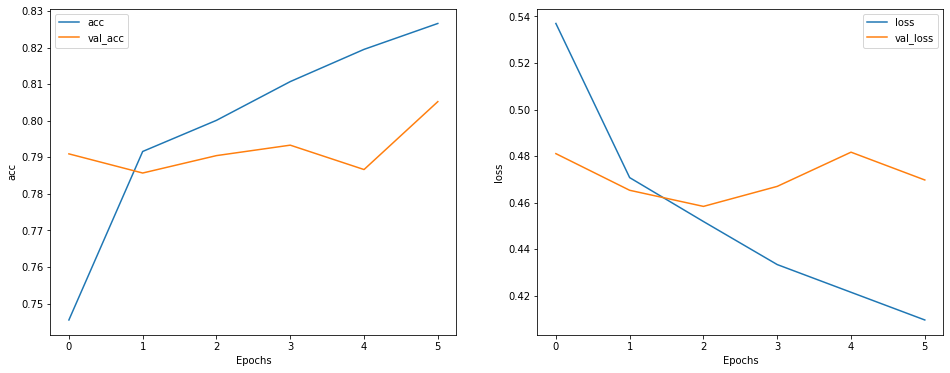

In [85]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'acc')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

### Hyperparameters Tuning

Now that we have made a first attempt to get our model's first prediction results in the base of accuracy perfomance, we are going to apply some hyperparameter tuning strategies. For that reason we tested 2 hyperpameter tuning that are included in the "Keras tuner" package : 

1. The first is the **Bayesian Optimization** algorithm which provides a seacrhing strategies based on the logic training the model for the given amount of epochs.
2. The we checked also the **Hyperband Optimization** algorithm where we set the maximum amount of epochs and then it applies the hyperparameter tuning in a the range of the given maximun epochs

In [86]:
#We define a function which constinst of the model strucure and our hyperparameter search domain for our model
def model_builder(hp):

  hp_dropout = hp.Float('Dropout', min_value=0.1, max_value=0.5, step=0.1)
  hp_lstm_units = hp.Int('Lstm_units', min_value=8, max_value=64, step=8)
  hp_lstm_dropout = hp.Float('Lstm_Dropout', min_value=0.1, max_value=0.5, step=0.1)
  # hp_desns_units = hp.Int('Dense_units', min_value=4, max_value=24, step=2)
  # hp_learning_rate = hp.Float('Learning_rate', min_value=0.00001, max_value=0.0001, step=-10)


  review_branch_ip = Input(shape=(100,), name='Review_input')
  review_branch = embedding_layer(review_branch_ip)
  review_branch = Dropout(hp_dropout)(review_branch)
  review_branch = Bidirectional(
      LSTM(hp_lstm_units, dropout=hp_lstm_dropout,recurrent_dropout=0)
  )(review_branch)
  review_branch = Dense(hp_lstm_units,activation='relu')(review_branch)
  review_branch_op = Dense(16, activation='relu')(review_branch)
 


  rating_branch_ip = Input(shape=(1,), name='Rating_input')
  rating_branch = Dense(8,activation='relu')(rating_branch_ip)
  rating_branch = Dropout(hp_dropout)(rating_branch)
  rating_branch_op = Dense(16,activation='relu')(rating_branch)
  



  verified_purchase_branch_ip = Input(shape=(1,), name='Verified_Purchase_input')
  verified_purchase_branch = Dense(8,activation='relu')(verified_purchase_branch_ip)
  verified_purchase_branch = Dropout(hp_dropout)(verified_purchase_branch)
  verified_purchase_branch_op = Dense(16,activation='relu')(verified_purchase_branch)


  concat = concatenate([review_branch_op, rating_branch_op, verified_purchase_branch_op], name='Concatenate')


  final_op = Dense(8, activation='relu')(concat)
  final_output = Dense(1,activation='sigmoid')(final_op)

  model = tf.keras.Model(inputs=[review_branch_ip,rating_branch_ip,verified_purchase_branch_ip], outputs=final_output,
                      name='Final_output')

  model.compile(optimizer=Adam(clipvalue=0.5) , 
               loss='binary_crossentropy', 
               metrics=['acc'])





  return model

In [87]:
#Early stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

<h5> Bayessian Hyperparameter Tunning </h5>

In [88]:
# This class sets up our Bayesian Tuner and then possibility to check our model based on different batch sizes
class MyTuner_Bayesian(kt.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', min_value=8, max_value=64, step=8) 
    
    super(MyTuner_Bayesian, self).run_trial(trial, *args, **kwargs)
   

In [89]:
b_tuner = MyTuner_Bayesian(model_builder,
                objective='val_acc',
                max_trials = 10,
                directory='Bayesian_Tuner',
                project_name='Bayesian_Amazon_reviews_tuner')

INFO:tensorflow:Reloading Oracle from existing project Bayesian_Tuner/Bayesian_Amazon_reviews_tuner/oracle.json


In [90]:
b_tuner.search([X_train_padded,train_rating,train_pursh], train_target, validation_data=([X_val_padded,valid_rating,valid_pursh], valid_target) , callbacks=[stop_early], epochs = 10)

Trial 14 Complete [00h 15m 52s]
val_acc: 0.8047618865966797

Best val_acc So Far: 0.808571457862854
Total elapsed time: 01h 38m 10s

Search: Running Trial #15

Hyperparameter    |Value             |Best Value So Far 
Dropout           |0.5               |0.1               
Lstm_units        |8                 |64                
Lstm_Dropout      |0.5               |0.5               
batch_size        |8                 |64                

Epoch 1/10
  81/2100 [>.............................] - ETA: 1:31 - loss: 0.6268 - acc: 0.7284

KeyboardInterrupt: ignored

In [91]:
# Get the optimal hyperparameters
best_b_hps=b_tuner.get_best_hyperparameters(num_trials=1)[0]

#Display the best hyperparameter that perfomed better based on the Bayesian Tuner
print(f"""
The hyperparameter search is complete. 
Dropout: {best_b_hps.get('Dropout')} ,
Batch_size: {best_b_hps.get('batch_size')},
Lstm_units: {best_b_hps.get('Lstm_units')} ,
Lstm_Dropout: {best_b_hps.get('Lstm_Dropout')}  
""")


The hyperparameter search is complete. 
Dropout: 0.1 ,
Batch_size: 64,
Lstm_units: 64 ,
Lstm_Dropout: 0.5  



<h5> Hyperband Hyperparameter Tunning </h5>

In [92]:
class MyTuner_Hyperband(kt.tuners.Hyperband):
  def run_trial(self, trial, *args, **kwargs):
    # You can add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', min_value=8, max_value=64, step=8) #USE 16 
    # kwargs['epochs'] = trial.hyperparameters.Int('epochs', min_value=5, max_value=15, step=5) #Int('epochs', 10, 20)
    super(MyTuner_Hyperband, self).run_trial(trial, *args, **kwargs) 

In [93]:
h_tuner = MyTuner_Hyperband(model_builder,
                     objective='val_acc',
                     max_epochs=10,
                     factor=3,
                     directory='Hyperband_Tuner',
                     project_name='Hyperband_Amazon_reviews_tuner')

In [94]:
h_tuner.search([X_train_padded,train_rating,train_pursh], train_target, validation_data=([X_val_padded,valid_rating,valid_pursh], valid_target) , callbacks=[stop_early], epochs = 10) 

Trial 30 Complete [00h 02m 16s]
val_acc: 0.7976190447807312

Best val_acc So Far: 0.808571457862854
Total elapsed time: 01h 06m 33s
INFO:tensorflow:Oracle triggered exit


In [100]:
# Get the optimal hyperparameters
best_h_hps=b_tuner.get_best_hyperparameters(num_trials=1)[0]

#Display the best hyperparameter that perfomed better based on the Bayesian Tuner
print(f"""
The hyperparameter search is complete. 
Dropout: {best_h_hps.get('Dropout')} ,
Batch_size: {best_h_hps.get('batch_size')},
Lstm_units: {best_h_hps.get('Lstm_units')} ,
Lstm_Dropout: {best_h_hps.get('Lstm_Dropout')}  
""")


The hyperparameter search is complete. 
Dropout: 0.1 ,
Batch_size: 64,
Lstm_units: 64 ,
Lstm_Dropout: 0.5  



<h5>Final Model</h5>

We observe that both hyperaparameter tuning algorithms converge on the same validation accuracy.

In order to finalize our model based on the hyperparameter results we are going to use the ones that we found from the Hyperband algorithm.

In [105]:
dropout = best_h_hps.get('Dropout')
lstm_units = best_h_hps.get('Lstm_units')
lstm_dropout = best_h_hps.get('Lstm_Dropout')
batch_size  = best_h_hps.get('batch_size')


In [109]:
review_branch_ip = Input(shape=(100,), name='Review_input')
review_branch = embedding_layer(review_branch_ip)
review_branch = Dropout(dropout)(review_branch)
review_branch = Bidirectional(
    LSTM(lstm_units, dropout=lstm_dropout,recurrent_dropout=0)
)(review_branch)
review_branch = Dense(lstm_units,activation='relu')(review_branch)
review_branch_op = Dense(16, activation='relu')(review_branch)



rating_branch_ip = Input(shape=(1,), name='Rating_input')
rating_branch = Dense(8,activation='relu')(rating_branch_ip)
rating_branch = Dropout(dropout)(rating_branch)
rating_branch_op = Dense(16,activation='relu')(rating_branch)




verified_purchase_branch_ip = Input(shape=(1,), name='Verified_Purchase_input')
verified_purchase_branch = Dense(8,activation='relu')(verified_purchase_branch_ip)
verified_purchase_branch = Dropout(dropout)(verified_purchase_branch)
verified_purchase_branch_op = Dense(16,activation='relu')(verified_purchase_branch)


concat = concatenate([review_branch_op, rating_branch_op, verified_purchase_branch_op], name='Concatenate')


final_op = Dense(8, activation='relu')(concat)
final_output = Dense(1,activation='sigmoid')(final_op)

model = Model(inputs=[review_branch_ip,rating_branch_ip,verified_purchase_branch_ip], outputs=final_output,
                name='Final_output')

In [111]:
# We compile with Adam and binary crossentropy loss 
# clipvalue to avoid the gradient exploding
model.compile(optimizer=Adam(clipvalue=0.5) , 
              loss='binary_crossentropy', 
              metrics=['acc'])

In [112]:
model.summary()

Model: "Final_output"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Review_input (InputLayer)       [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 100)     4094100     Review_input[0][0]               
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 100, 100)     0           embedding[0][0]                  
__________________________________________________________________________________________________
Rating_input (InputLayer)       [(None, 1)]          0                                            
_______________________________________________________________________________________

In [113]:
stop_early_model = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit([X_train_padded,train_rating,train_pursh], train_target, batch_size=batch_size,epochs=10, validation_data=([X_val_padded,valid_rating,valid_pursh], valid_target),callbacks=[stop_early_model])

Epoch 1/10
263/263 [==============================] - 20s 57ms/step - loss: 0.6226 - acc: 0.6648 - val_loss: 0.5115 - val_acc: 0.7824
Epoch 2/10
263/263 [==============================] - 13s 50ms/step - loss: 0.5084 - acc: 0.7780 - val_loss: 0.4810 - val_acc: 0.7838
Epoch 3/10
263/263 [==============================] - 13s 49ms/step - loss: 0.4860 - acc: 0.7812 - val_loss: 0.4654 - val_acc: 0.7919
Epoch 4/10
263/263 [==============================] - 13s 49ms/step - loss: 0.4656 - acc: 0.7970 - val_loss: 0.4683 - val_acc: 0.7981
Epoch 5/10
263/263 [==============================] - 13s 50ms/step - loss: 0.4682 - acc: 0.7911 - val_loss: 0.4642 - val_acc: 0.7971
Epoch 6/10
263/263 [==============================] - 13s 50ms/step - loss: 0.4622 - acc: 0.7962 - val_loss: 0.4606 - val_acc: 0.8010
Epoch 7/10
263/263 [==============================] - 13s 49ms/step - loss: 0.4463 - acc: 0.8040 - val_loss: 0.4585 - val_acc: 0.7971
Epoch 8/10
263/263 [==============================] - 13s 49ms

<h5>Plotting the results</h5>

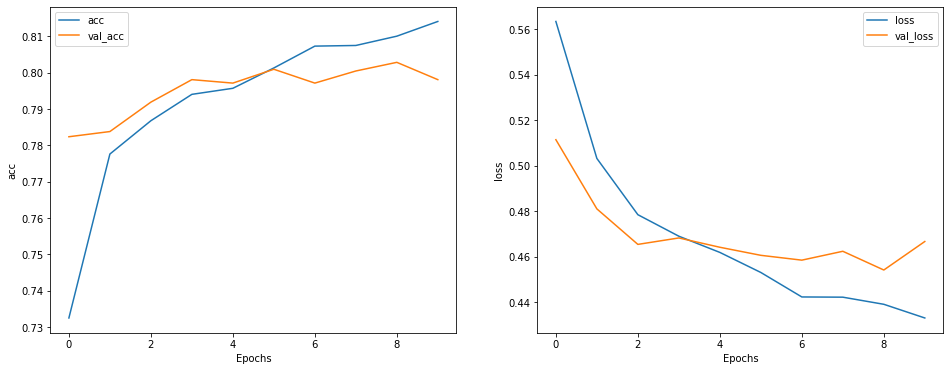

In [114]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'acc')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

<h5>Evaluate the model</h5>

In [116]:
model.evaluate([X_test_padded,test_rating,test_pursh], test_target, verbose=2)

66/66 - 1s - loss: 0.4636 - acc: 0.8110


[0.4636394679546356, 0.810952365398407]

Save the model

In [117]:
model.save('w2vblstm.h5') 